In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install torch==1.6.0+cu101 torchvision==0.8.1+cu101 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0MB 25kB/s 
     |████████████████████████████████| 12.7MB 53.9MB/s 
     |████████████████████████████████| 7.6MB 8.4MB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.6.0+cu101 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0+cu101 which is incompatible.
ERROR: torchaudio 0.7.0 has requirement torch==1.7.0, but you'll have torch 1.6.0+cu101 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [ ]:
import torch
import numpy as np
import pandas as pd
from collections import OrderedDict
#from pytorch_transformers import BertTokenizer, BertConfig
#from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM
import torch
import logging
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import nltk
import torch.optim as optim
print(torch.__version__)

1.6.0+cu101


In [ ]:
nltk.download('punkt')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
pip install sacremoses


     |████████████████████████████████| 901kB 8.7MB/s 


In [ ]:
pip install boto3

     |████████████████████████████████| 133kB 8.6MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
     |████████████████████████████████| 7.6MB 50.9MB/s 
     |████████████████████████████████| 143kB 56.1MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:

#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl

In [ ]:

dev = "cuda"
import sys
import os
sys.path.append(os.path.abspath('/content/drive/My Drive/Colab Notebooks'))


In [ ]:
from __future__ import absolute_import, division, print_function


import pdb
import argparse
import glob
import logging

import os
import pickle
import random

import numpy as np
import torch
import torch.nn.init as init
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
#from tensorboardX import SummaryWriter
from tqdm import tqdm, trange
from collections import defaultdict

# from azure.cosmosdb.table.tableservice import TableService
# from azure.cosmosdb.table.models import Entity
from datetime import datetime



from pytorch_transformers import (WEIGHTS_NAME, AdamW, WarmupLinearSchedule,
                                  BertConfig, BertForLatentConnector, BertTokenizer,
                                  GPT2Config, GPT2ForLatentConnector, GPT2Tokenizer,
                                  OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer,
                                  RobertaConfig, RobertaForMaskedLM, RobertaTokenizer)

from utils import (weight_init, calc_iwnll, calc_rec, calc_mi, calc_au, BucketingDataLoader, TextDataset_Split, TextDataset_2Tokenizers, frange_cycle_linear, frange_cycle_zero_linear)
import utils

from modules import VAE


# logging.getLogger("azure").setLevel(logging.WARNING)
# logging.getLogger("TableService").setLevel(logging.WARNING)

logger = logging.getLogger(__name__)


MODEL_CLASSES = {
    'gpt2': (GPT2Config, GPT2ForLatentConnector, GPT2Tokenizer),
    'openai-gpt': (OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer),
    'bert': (BertConfig, BertForLatentConnector, BertTokenizer),
    'roberta': (RobertaConfig, RobertaForMaskedLM, RobertaTokenizer)
}

import modules


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
encoder_model_type = 'bert'
encoder_model_name = 'bert-base-cased'
decoder_model_type= 'gpt2'
decoder_model_name = 'gpt2'

In [ ]:
encoder_config_class, encoder_model_class, encoder_tokenizer_class = MODEL_CLASSES[encoder_model_type]
encoder_config = encoder_config_class.from_pretrained(encoder_model_name)
model_encoder = encoder_model_class.from_pretrained(encoder_model_name, from_tf=bool('.ckpt' in encoder_model_name), config=encoder_config, latent_size=32)
tokenizer_encoder = encoder_tokenizer_class.from_pretrained(encoder_model_name)

100%|██████████| 213450/213450 [00:00<00:00, 848632.50B/s]


In [ ]:
decoder_config_class, decoder_model_class, decoder_tokenizer_class = MODEL_CLASSES[decoder_model_type]
decoder_config = decoder_config_class.from_pretrained(decoder_model_name)
tokenizer_decoder = decoder_tokenizer_class.from_pretrained(decoder_model_name)
model_decoder = decoder_model_class.from_pretrained(decoder_model_name, from_tf=bool('.ckpt' in decoder_model_name), config=decoder_config, latent_size=32, latent_as_gpt_emb=True, latent_as_gpt_memory=True)

100%|██████████| 548118077/548118077 [00:13<00:00, 39807543.36B/s]


In [ ]:
#pip install torch_xla
tokenizer_decoder2 = tokenizer_decoder

Load the Optimus Model with the ARGS as provided

In [ ]:


class ARGS():
    def __init__(self): # 
        self.encoder_model_type = 'bert'
        self.encoder_model_name = 'bert-base-cased'
        self.decoder_model_type= 'gpt2'
        self.decoder_model_name = 'gpt2'
        self.beta = 0.5
        self.latent_size = 32
        self.fb_mode = 0
        self.length_weighted_loss = True 
        self.device = dev
        self.block_size = 52
        self.temperature = 1
        self.top_k = 5
        self.top_p = 0

#model_encoder.to(dev)
#model_decoder.to(dev)

special_tokens_dict = {'pad_token': '<PAD>', 'bos_token': '<BOS>', 'eos_token': '<EOS>'}
num_added_toks = tokenizer_decoder.add_special_tokens(special_tokens_dict)
print('We have added', num_added_toks, 'tokens to GPT2', 'total length = ', len(tokenizer_decoder))
model_decoder.resize_token_embeddings(len(tokenizer_decoder))  # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e. the length of the tokenizer.
assert tokenizer_decoder.pad_token == '<PAD>'

num_added_toks = tokenizer_decoder2.add_special_tokens(special_tokens_dict)
print('We have added', num_added_toks, 'tokens to GPT2', 'total length = ', len(tokenizer_decoder2))
model_decoder.resize_token_embeddings(len(tokenizer_decoder2))  # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e. the length of the tokenizer.
assert tokenizer_decoder.pad_token == '<PAD>'

    # model_decoder.to(args.device)
args = ARGS()
model_vae = modules.VAE(model_encoder, model_decoder, tokenizer_encoder, tokenizer_decoder, args)
#a = torch.load("/content/drive/My Drive/Optimus/NLP/checkpoint-508523/checkpoint_cara3.pth", map_location='cpu')

We have added 0 tokens to GPT2 total length =  50260
We have added 0 tokens to GPT2 total length =  50260


In [ ]:
bos_token_id = tokenizer_decoder.encode('<BOS>')[0]
eos_token_id = tokenizer_decoder.encode('<EOS>')[0]
pad_token_id = tokenizer_decoder.encode('<PAD>')[0]

In [ ]:
def mask_tokens(inputs, tokenizer, args):
    """ Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original. """
    labels = inputs.clone()
    # We sample a few tokens in each sequence for masked-LM training (with probability args.mlm_probability defaults to 0.15 in Bert/RoBERTa)
    
    masked_indices = torch.bernoulli(torch.full(labels.shape, 0.15)).to(torch.uint8)
    labels[masked_indices==1] = -1  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).to(torch.uint8) & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).to(torch.uint8) & masked_indices & ~indices_replaced
    indices_random = indices_random
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [ ]:
def tokenize_sentence(inputs, pad_token, max_length):
  id_tokens = []
  i = 0
  for g in inputs:
    temp = nltk.word_tokenize(g)
    temp.insert(0,'[CLS]')
    temp.append('[Sep]')
    id_tokens.append(tokenizer_encoder.convert_tokens_to_ids(temp))
    for k in range(len(id_tokens[i]),max_length):
      id_tokens[i].append(pad_token)
    i = i+1

  return id_tokens


  

Code for Preprocessing Text is provided in the next cell but we provide you with the preprocessed data (go directly to load the preprocessed data)

In [ ]:
f = open(r"/content/drive/My Drive/Optimus/NLP/data/data/train.txt", encoding="utf8")
x_encoder = []
x_decoder = []

for g in f:
    temp = nltk.word_tokenize(g)
      temp = temp[2:]
      temp_dec = temp.copy()
      temp.insert(0,'[CLS]')
      temp.append('[Sep]')
      x_encoder.append(temp)
      x_decoder.append(temp_dec)
      count = count+1
      if count > 500000:
        break
id_tokens = []
for a in x_encoder:
    id_tokens.append(tokenizer_encoder.convert_tokens_to_ids(a))

id_tokens_decoder = []
for a in x_decoder:
    temp = tokenizer_decoder2(a)['input_ids']
    temp2 = []
    for i in temp:
      for b in i:
        temp2.append(b)
    temp2 = [tokenizer_decoder2.bos_token_id] + temp2 + [tokenizer_decoder2.eos_token_id]
    id_tokens_decoder.append(temp2)

In [ ]:
def pad_sents(sents1, sents2, pad_token1, pad_token2):
    """ Pad list of sentences according to the longest sentence in the batch.
        The paddings should be at the end of each sentence.
    @param sents (list[list[str]]): list of sentences, where each sentence
                                    is represented as a list of words
    @param pad_token (str): padding token
    @returns sents_padded (list[list[str]]): list of sentences where sentences shorter
        than the max length sentence are padded out with the pad_token, such that
        each sentences in the batch now has equal length.
    """
    sents_padded1 = sents1.copy()
    sents_padded2 = sents2.copy()
    max_length = 0
    for i in range(len(sents1)):
        if len(sents1[i]) > max_length:
            max_length = len(sents1[i]) 
  
    for i in range(len(sents2)):
        if len(sents2[i]) > max_length:
            max_length = len(sents2[i]) 

    for i in range(len(sents1)):
        for k in range(len(sents_padded1[i]),max_length):
            sents_padded1[i].append(pad_token1)

    for i in range(len(sents2)):
        for k in range(len(sents_padded2[i]),max_length):
            sents_padded2[i].append(pad_token2)

    ### END YOUR CODE

    return sents_padded1, sents_padded2 



In [ ]:
padded_input_tokens, padded_output_tokens = pad_sents(id_tokens,id_tokens_decoder, 0, tokenizer_decoder.pad_token_id)
tokenized_text0 = torch.tensor(padded_input_tokens)
tokenized_text1 = torch.tensor(padded_output_tokens)

Load the preprocessed text files directly

In [ ]:
inputs = torch.load("/content/drive/My Drive/Optimus/NLP/inputs.pth")
labels = torch.load("/content/drive/My Drive/Optimus/NLP/labels.pth")  # Note that labels here are the outputs for the decoder

Training and load the pretrained weights of Optimus Model

In [ ]:
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
        {'params': [p for n, p in model_vae.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5,eps=1e-8)
dev = 'cuda'
inputs = inputs.to(dev)
labels = labels.to(dev)
#model_vae.to('cuda')
a = torch.load("/content/drive/My Drive/Optimus/NLP/beta_0/checkpoint-508523/checkpoint-full-508523/training.bin", map_location='cpu')
model_vae.load_state_dict(a['model_state_dict'], strict = False)
#model_vae.load_state_dict(a)
model_vae.to(dev)
del a

In [ ]:

permutation = torch.randperm(inputs.size()[0])
loss_kl_array = []
loss_array = []
import time
torch.autograd.set_detect_anomaly(True)
n_epochs = 1# or whatever
batch_size = 32 # or whatever
for epoch in range(n_epochs):
    start1 = time.time()
    count = 0
    for i in range(0,inputs.size()[0], batch_size):
        start = time.time()
        optimizer.zero_grad()
        indices = permutation[i:i+batch_size]
        batch_inputs, batch_labels = inputs[indices], labels[indices]

        model_vae.args.beta = 0          # Change this to 0.5 for beta = 0.5

        model_vae.args.fb_mode = 2

        loss_rec, loss_kl, loss = model_vae(batch_inputs, batch_labels)
        loss_kl_array.append(loss_kl.sum().detach())
        loss_array.append(loss.sum().detach())
        
        loss.sum().backward()
        optimizer.step()

        if count%100 == 0:
          print((time.time()-start1)/60)
          print(loss_kl.sum(), loss.sum())
        count = count + 1

    print(time.time()-start) 

Beta = 0

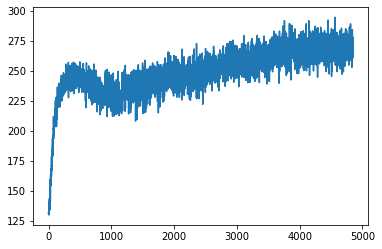

In [ ]:
plt.plot(loss_kl_array)

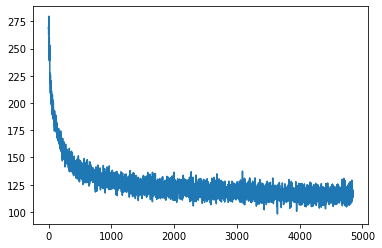

In [ ]:
plt.plot(loss_array)

Beta = 0.5

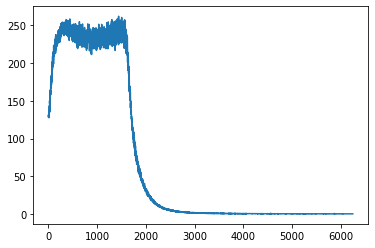

In [ ]:
plt.plot(loss_kl_array)

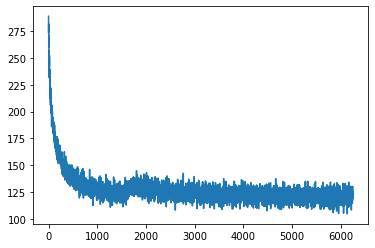

In [ ]:
plt.plot(loss_array)

In [ ]:
dev = 'cuda'
model_vae.to(dev)
inputs = inputs.to(dev)
labels = labels.to(dev)
r = model_vae.generation(inputs[10:12])


start
1
tensor([[50258,   464,  3823],
        [50258,   464, 28120],
        [50258,   464, 28120],
        [50258,   464, 28120],
        [50258,   464, 28120]], device='cuda:0')
tensor([[50258,   464,  3823],
        [50258,   464, 28120],
        [50258,   464, 28120],
        [50258,   464, 28120],
        [50258,   464, 28120]], device='cuda:0')
tensor([[50258,   464,  3823],
        [50258,   464, 28120],
        [50258,   464, 28120],
        [50258,   464, 28120],
        [50258,   464, 28120]], device='cuda:0')
tensor([[50258,   464,  3823],
        [50258,   464, 28120],
        [50258,   464, 28120],
        [50258,   464, 28120],
        [50258,   464, 28120]], device='cuda:0')
tensor([[50258,   464,  3823],
        [50258,   464, 28120],
        [50258,   464, 28120],
        [50258,   464, 28120],
        [50258,   464, 28120]], device='cuda:0')
tensor([[50258,  1858,   271],
        [50258,  1858,   271],
        [50258,  1858,  9776],
        [50258,  1858,   318],
   